In [133]:
from datetime import datetime
import pandas as pd
import numpy as np
from brainflow.board_shim import BoardIds, BoardShim, BrainFlowInputParams, LogLevels
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations, DetrendOperations, WindowFunctions
import matplotlib.pyplot as plt

In [134]:
sesh_num = "11_SYNTH"
today = datetime.today().strftime('%Y_%m_%d')
# today = '2020_12_21'
csv_path = f"../sessions_archive/{today}/Session_{sesh_num}/raw_data.csv"
df_raw = pd.read_csv(csv_path, index_col=0)

In [135]:
df = df_raw.drop(['aux_1', 'aux_2', 'aux_3'], axis=1)

In [136]:
"""Allow us to view the effect of various filters and transformations"""
def display_transform(np_data, title):
    q = pd.DataFrame(np_data.transpose(), index=df.index, columns=df.columns).iloc[:200,:]
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    fig, axs = plt.subplots(nrows=len(q.columns), ncols=2, figsize=(15,25), constrained_layout=True)
    plt.style.use('seaborn')
    fig.suptitle(title, fontsize=15)
    for idx, col in enumerate(q.columns):
        color = colors[idx % len(colors)]
        curr_col = q.loc[:,col].transpose()
        axs[idx, 0].plot(q.index, curr_col, color=color)
        axs[idx, 0].set_ylabel(col, fontsize=15)
        axs[idx, 0].set_xlabel('')
        axs[idx, 0].tick_params(labelsize=9)
        axs[idx, 0].set_xticks([])
        axs[idx, 0].ticklabel_format(style='plain',scilimits=(0,0), useOffset=False)

        axs[idx, 1].magnitude_spectrum(curr_col, Fs=sampling_rate, scale='dB', color=color)
        axs[idx, 1].set_ylabel('')
        axs[idx, 1].set_xlabel('')
        axs[idx, 1].tick_params(labelsize=9)
    plt.show()

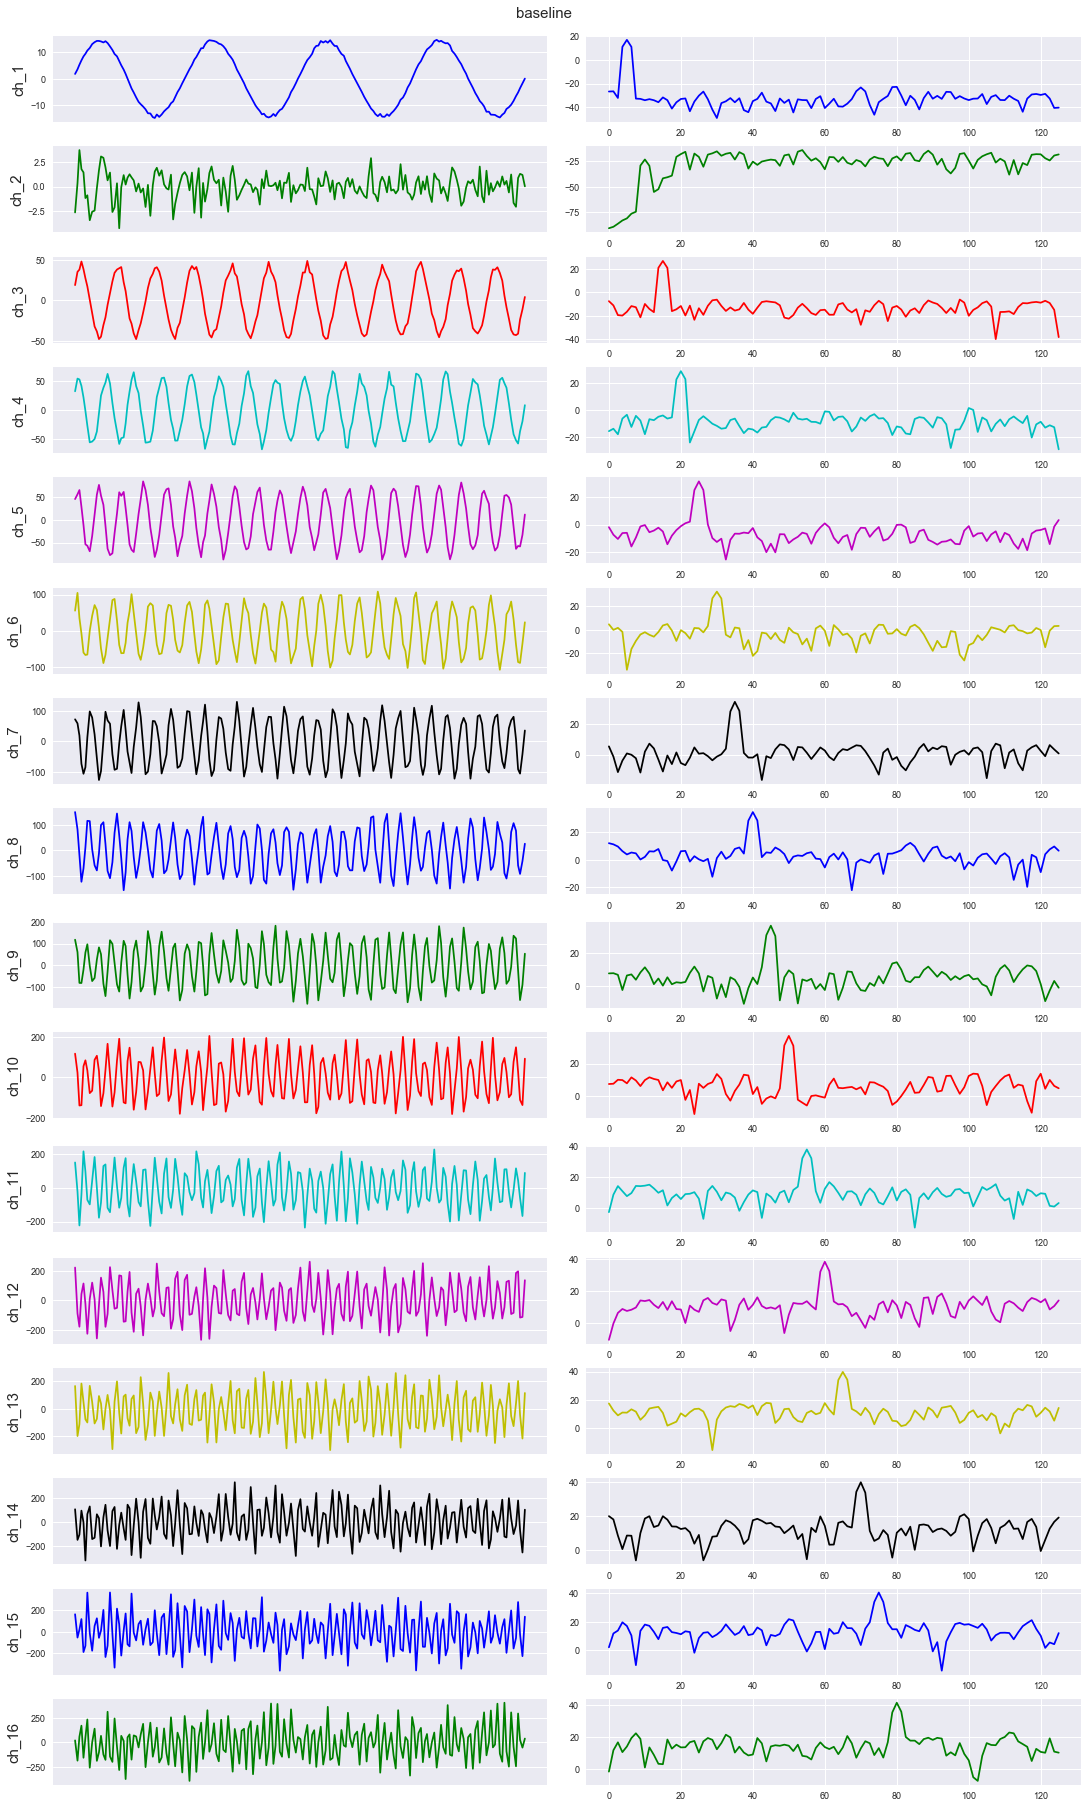

In [137]:
display_transform(np.array(df).transpose(), "baseline")

## Create notch filtered data

In [138]:
board_id = BoardIds.SYNTHETIC_BOARD.value
sampling_rate = BoardShim.get_sampling_rate(board_id)

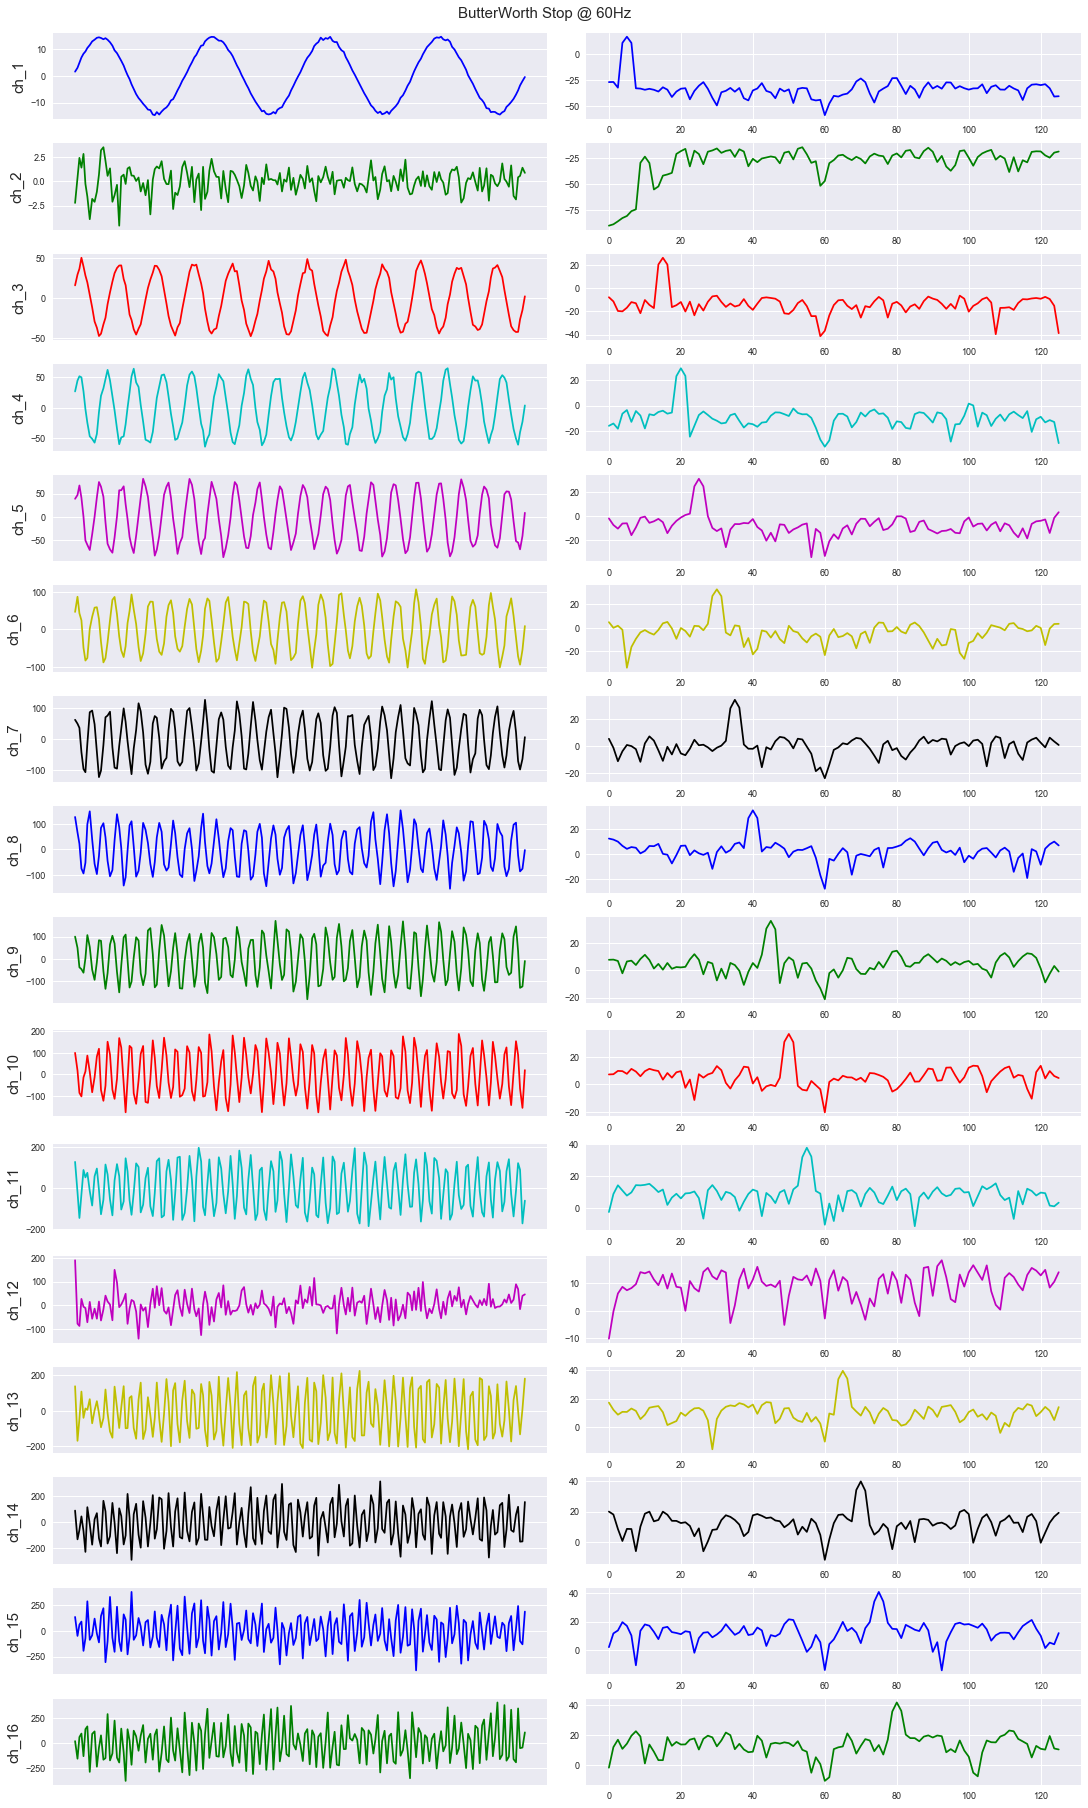

In [139]:
notch_filtered = np.array(df.transpose())
for r in notch_filtered:
    DataFilter.perform_bandstop(r, sampling_rate, 60.0, 5.0, 4, FilterTypes.BUTTERWORTH.value, 0.0)
display_transform(notch_filtered, "ButterWorth Stop @ 60Hz")

## Denoise the notched Data

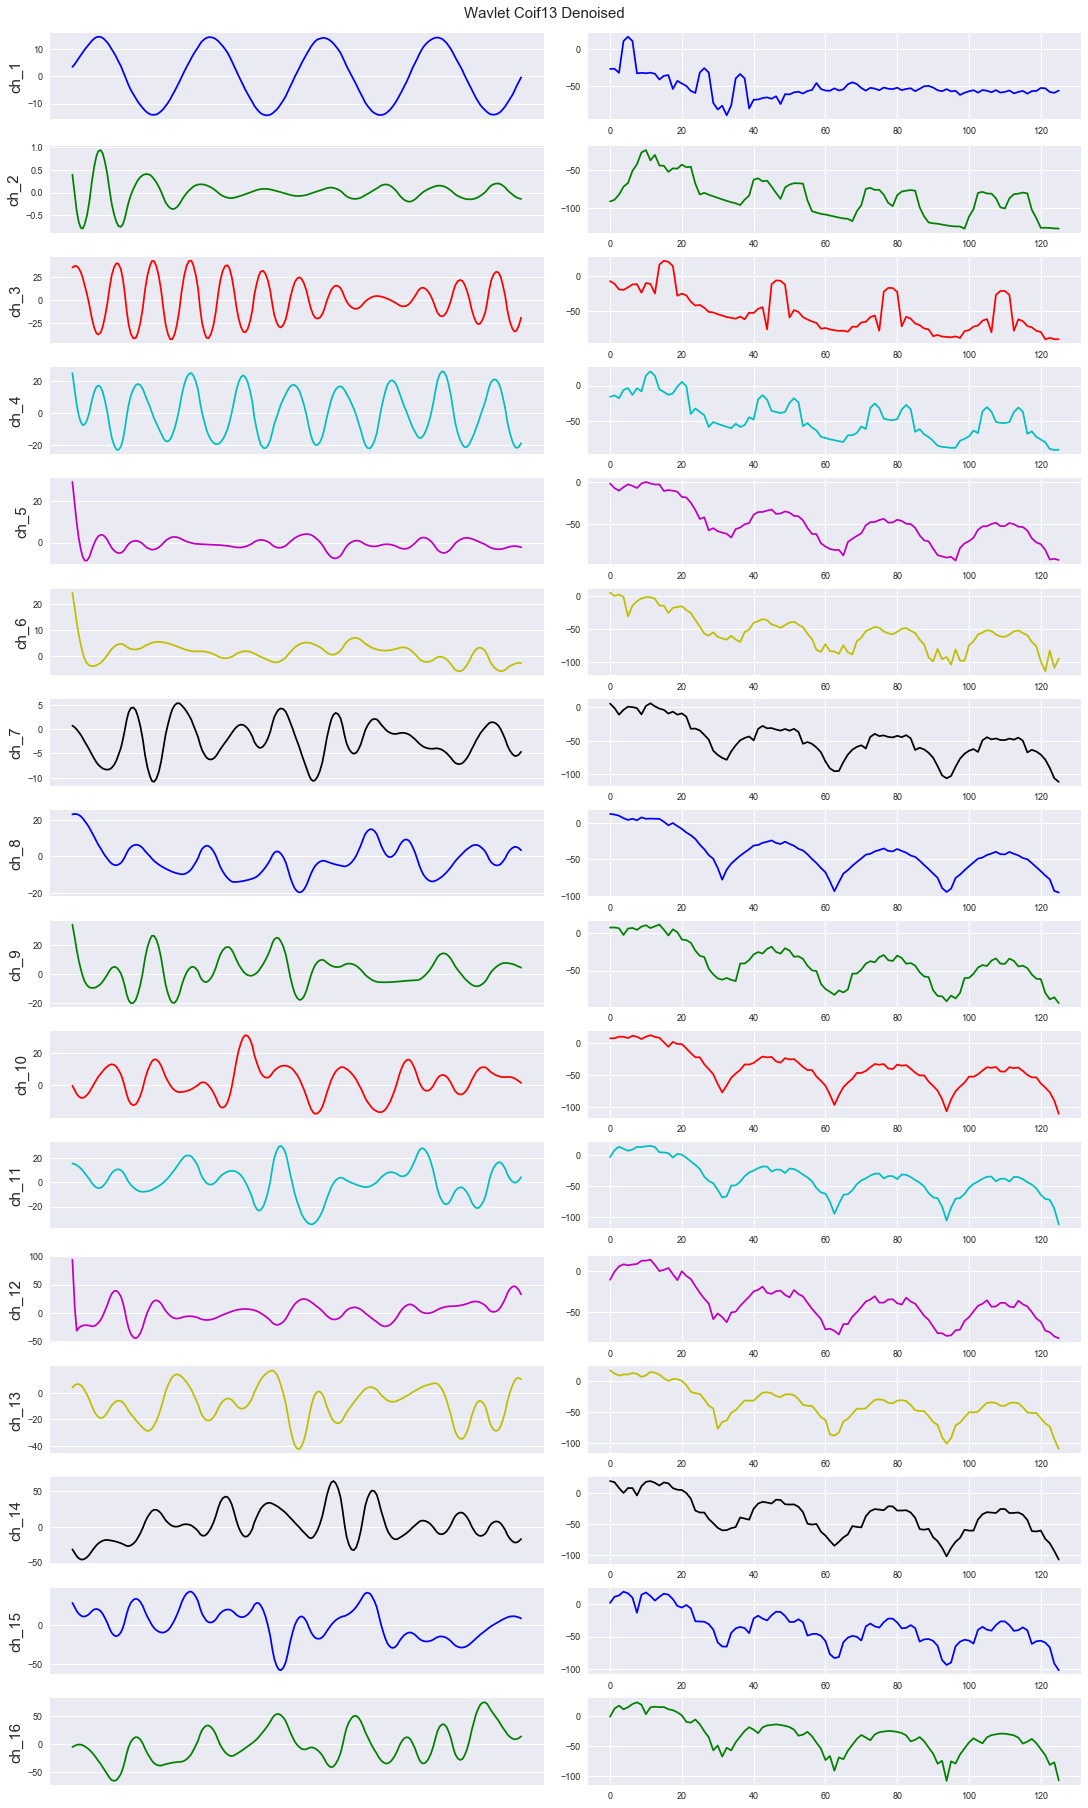

In [131]:
wavlet_denoised = np.copy(notch_filtered)
for r in wavlet_denoised:
    DataFilter.perform_wavelet_denoising(r, 'bior3.9', 3)
display_transform(wavlet_denoised, "Wavlet Coif13 Denoised")

## Do some transforms (FFT, Wavelet)

In [42]:
nfft = DataFilter.get_nearest_power_of_two(sampling_rate)

In [43]:
dfp = df.copy().head(200)
for c in dfp.columns:
    

DataFilter.detrend(dfp.iloc[:,1].values, detrend_operation=DetrendOperations.LINEAR.value)

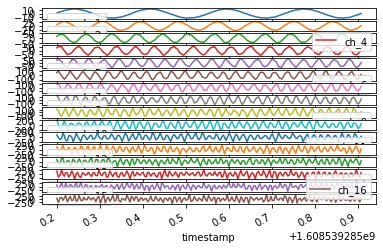

In [44]:
dfp.head(200).plot(subplots=True)
plt.show()

In [62]:
x = dfp.values.transpose()

In [73]:
for col in range(len(x)):
    DataFilter.detrend(x[col], DetrendOperations.LINEAR.value)
    psd = DataFilter.get_psd_welch(x[col], nfft, nfft // 2 , sampling_rate, WindowFunctions.BLACKMAN_HARRIS.value)
    alpha = DataFilter.get_band_power(psd, 7., 13.)
    beta = DataFilter.get_band_power(psd, 14., 30.)
    print(f"col {col} has alpha {alpha} and beta {beta}")

col 0 has alpha 0.005425307936356493 and beta 0.002332047318099108
col 1 has alpha 102.85195209030404 and beta 0.043366396242606076
col 2 has alpha 15.014711061604357 and beta 151.1444355764111
col 3 has alpha 0.35163630099363435 and beta 410.68175782584643
col 4 has alpha 0.7888890390695547 and beta 641.5892141079855
col 5 has alpha 1.1589890740177284 and beta 543.0668098411722
col 6 has alpha 3.0859167708350665 and beta 8.029075779891269
col 7 has alpha 3.4451609173512985 and beta 8.069047405273308
col 8 has alpha 8.421761007932655 and beta 15.487336879317208
col 9 has alpha 11.860820958638753 and beta 20.113507765086943
col 10 has alpha 10.638619172694234 and beta 50.26120903889687
col 11 has alpha 14.246433875686545 and beta 54.67492897868049
col 12 has alpha 26.69334682585945 and beta 90.9790000278994
col 13 has alpha 23.73378204626504 and beta 103.85032304922848
col 14 has alpha 69.17059342339653 and beta 160.99394646568055
col 15 has alpha 56.56110836212879 and beta 165.58061116

In [77]:
eegs = list(range(16))#BoardShim.get_eeg_channels(board_id)
DataFilter.get_avg_band_powers(x, eegs, sampling_rate, True)

(array([0.01293178, 0.02543301, 0.04073694, 0.34302723, 0.57787104]),
 array([1.436778  , 1.23198145, 1.37887793, 1.28667345, 1.71002363]))

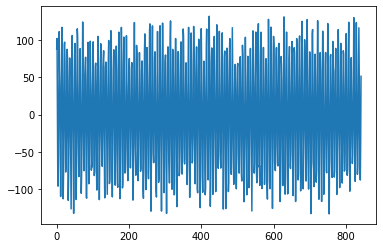

In [70]:
_ = plt.plot(dfp.values.transpose()[6])

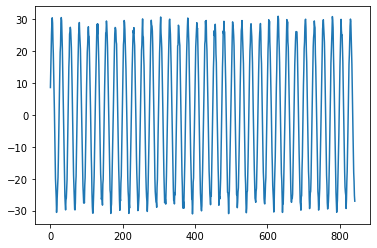

In [66]:
_= plt.plot(x[1])